In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader

import cv2
from glob import glob
from tqdm import tqdm


In [26]:
device = torch.device('cpu')

In [27]:
!pwd

/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook


In [28]:
image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/classification/ISIC_2019_Training_Input/'

In [29]:
metadata_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data\
/classification/ISIC_2019_Training_Metadata.csv'


In [30]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


In [31]:
ground_true = pd.read_csv('/scratch/cz2064/myjupyter/Computer Vision/Project/Data\
/classification/ISIC_2019_Training_GroundTruth.csv')
ground_true

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df = pd.DataFrame.merge(metadata_df,ground_true)
df

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df['sex'] = df['sex'].astype('category')

In [34]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns+'_index'] = df[cat_columns].apply(lambda x: x.cat.codes)
df['age_index'] = df['age_approx']/100
df = pd.concat([df,pd.get_dummies(df['anatom_site_general'])], axis=1)
df

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,sex_index,age_index,anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,...,0,0.55,1,0,0,0,0,0,0,0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,...,0,0.30,1,0,0,0,0,0,0,0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,...,0,0.60,0,0,0,0,0,0,0,1
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,...,1,0.30,0,0,0,0,0,0,0,1
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,...,1,0.80,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,...,0,0.85,0,1,0,0,0,0,0,0
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,...,1,0.65,1,0,0,0,0,0,0,0
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,...,1,0.70,0,0,0,1,0,0,0,0
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,...,0,0.55,0,0,0,0,0,1,0,0


## Train Val Test Split

In [35]:
idx = np.arange(len(df))
np.random.seed(0)
np.random.shuffle(idx)
val_size = int(len(df)/5) # 20% validation
test_size = int(len(df)/5) # 20% test
train_size = len(df) - val_size - test_size
train_idx = idx[:train_size]
val_idx = idx[train_size:train_size+val_size]
test_idx = idx[train_size+val_size:]
train_df = df.iloc[train_idx,:]
val_df = df.iloc[val_idx,:]
test_df = df.iloc[test_idx,:]
train_df

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,sex_index,age_index,anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity
12460,ISIC_0033863,65.0,posterior torso,HAM_0007086,female,1.0,0.0,0.0,0.0,0.0,...,0,0.65,0,0,0,0,0,0,1,0
11304,ISIC_0032707,55.0,posterior torso,HAM_0007124,male,0.0,1.0,0.0,0.0,0.0,...,1,0.55,0,0,0,0,0,0,1,0
4630,ISIC_0026033,60.0,lower extremity,HAM_0003319,female,0.0,1.0,0.0,0.0,0.0,...,0,0.60,0,0,0,1,0,0,0,0
12510,ISIC_0033913,75.0,posterior torso,HAM_0001855,male,0.0,0.0,0.0,0.0,1.0,...,1,0.75,0,0,0,0,0,0,1,0
12337,ISIC_0033740,25.0,head/neck,HAM_0005997,female,0.0,1.0,0.0,0.0,0.0,...,0,0.25,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,ISIC_0011140,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,...,0,0.60,0,0,0,0,0,0,0,1
5537,ISIC_0026940,75.0,lower extremity,HAM_0005973,male,0.0,0.0,1.0,0.0,0.0,...,1,0.75,0,0,0,1,0,0,0,0
21307,ISIC_0066907,45.0,lower extremity,BCN_0000761,male,1.0,0.0,0.0,0.0,0.0,...,1,0.45,0,0,0,1,0,0,0,0
23101,ISIC_0069691,35.0,upper extremity,BCN_0001737,male,0.0,1.0,0.0,0.0,0.0,...,1,0.35,0,0,0,0,0,0,0,1


In [36]:
train_df.to_csv('train.csv', index = False)
val_df.to_csv('val.csv', index = False)
test_df.to_csv('test.csv', index = False)

In [59]:
train_df[['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']]\
.groupby(['MEL','NV'],as_index=False)['MEL','NV']



/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [65]:
train_df['MEL'].value_counts()

0.0    12516
1.0     2683
Name: MEL, dtype: int64

In [74]:
category = train_df[['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']]
category

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
12460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4630,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12510,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12337,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1118,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5537,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
#train_df.set_index('ID',inplace=True)
category = train_df[['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']]
category = category[category==1].stack().reset_index().drop(0,1)
category = category['level_1'].value_counts()
count_df = pd.DataFrame(data=0, index=['number','ratio'],\
                        columns=['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK','total'])
count_df[['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']]
count_df.loc['number',['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']] = category
count_df.loc['number','total'] = sum(category)
count_df.loc['ratio'] = count_df.loc['number']/sum(category)
count_df

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,total
number,2683.000000,7707.000000,2025.000000,509.000000,1595.000000,136.000000,150.000000,394.000000,0.0,15199.0
ratio,0.176525,0.507073,0.133232,0.033489,0.104941,0.008948,0.009869,0.025923,0.0,1.0


In [176]:
count_df.loc['ratio'].values[:-1]

array([0.17652477, 0.50707283, 0.13323245, 0.03348905, 0.10494111,
       0.00894796, 0.00986907, 0.02592276, 0.        ])

## Load sample

In [12]:
df.loc[0,'image']

'ISIC_0000000'

<class 'PIL.JpegImagePlugin.JpegImageFile'>


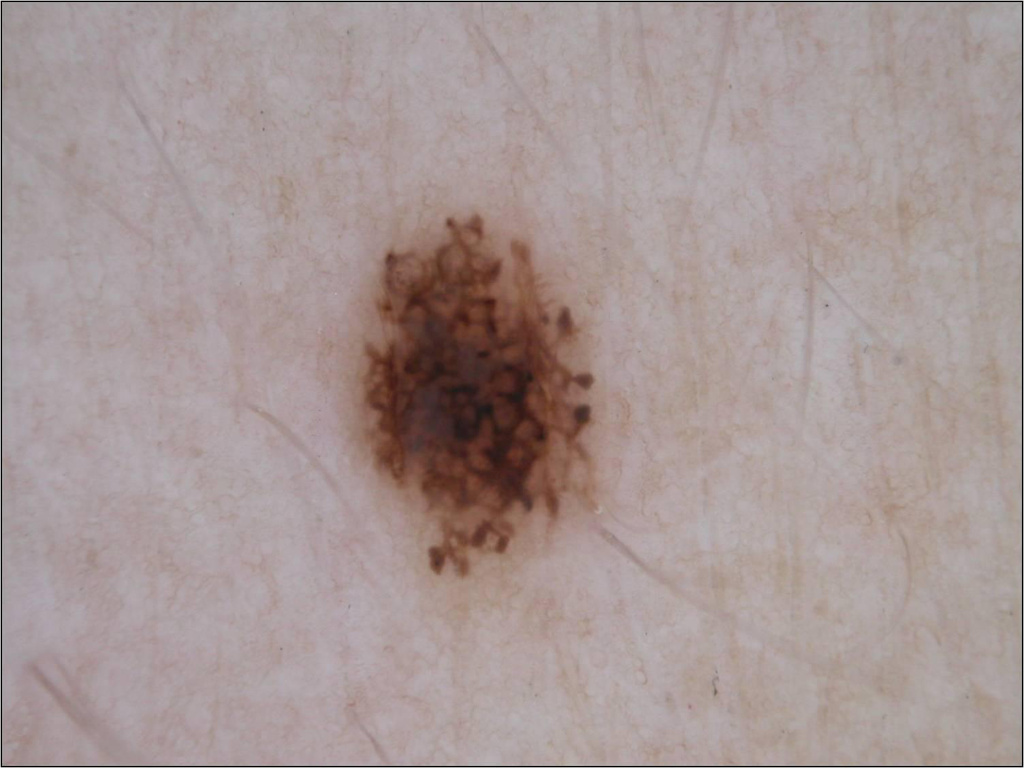

In [22]:
sample_path = image_path+df.loc[60,'image']+'.jpg'
sample = Image.open(sample_path)
print(type(sample))
sample

In [14]:
ToTensor()(sample).size()

torch.Size([3, 768, 1024])

In [15]:
ToTensor()(sample).size()

torch.Size([3, 768, 1024])

## Shades of Gray color constancy

In [19]:
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

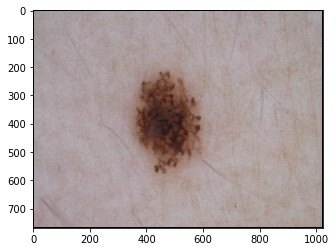

In [26]:
sample_array = np.array(sample)
plt.imshow(sample_array)

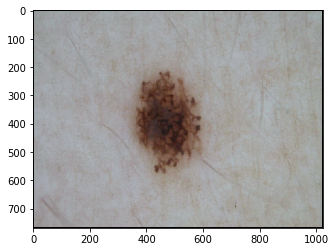

In [27]:
plt.imshow(shade_of_gray_cc(sample_array))